# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# 1. Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [23]:
import pandas as pd
import numpy as np
import math
import json
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# 2. Loading the dataset

In [24]:
# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [57]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [25]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [26]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [27]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# 3. Data Cleaning

## 3.1. Clean Portfolio, Profile, and Transcript datasets

In [58]:
def map_channel_type(channels):
    if channels == ['web', 'email', 'mobile', 'social']:
        return 0
    elif channels == ['web', 'email', 'mobile']:
        return 1
    elif channels == ['email', 'mobile', 'social']:
        return 2
    elif channels == ['web', 'email']:
        return 3
    else:
        return None

def portfolio_clean(df):
    # Copy portfolio dataframe
    clean_df = df.copy()

    # Convert the column 'channels' into 4 different channels.
    channel_df = pd.get_dummies(clean_df['channels'].apply(pd.Series).stack()).groupby(level=0).sum()
    clean_df = pd.concat([clean_df, channel_df], axis=1)
    
    # Convert the column 'channels' from list to numerical type
    clean_df['channels'] = clean_df['channels'].apply(map_channel_type)

    return  clean_df

In [59]:
def profile_clean(df):
    clean_df = df.copy()

    # Convert became_member_on to datetime format and extract the year
    clean_df['became_member_on'] = pd.to_datetime(clean_df['became_member_on'], format='%Y%m%d')
    clean_df['year'] = clean_df['became_member_on'].dt.year
    
    # df['age'] = df['age'].replace(118, np.nan)
    clean_df['age'] = clean_df['age'].replace(118, np.nan)

    return  clean_df

In [60]:
def transcript_clean(df):
    clean_df = df.copy()
    
    # Clean the value column
    clean_df['offer_id'] = clean_df['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
    clean_df['amount'] = clean_df['value'].apply(lambda x: x.get('amount', 0))
    clean_df.drop('value', axis=1, inplace=True)

    return  clean_df

In [61]:
portfolio_df = portfolio_clean(portfolio)
profile_df = profile_clean(profile)
transcript_df = transcript_clean(transcript)

## 3.2. Merge 3 datasets

In [62]:
# Merge profile_df into transcript_df
df = transcript_df.merge(profile_df, left_on='person', right_on='id', how='outer')

# Drop the repeated column after combine
df.drop('id', axis=1, inplace=True)  

In [63]:
# Merge portfolio_df into general df
df = df.merge(portfolio_df, left_on='offer_id', right_on='id', how='outer')

# Drop the repeated column after combine
df.drop(['id'], axis=1, inplace=True)

In [64]:
df = df.rename(columns={'person':'customer_id'})
df.drop_duplicates(inplace = True)
df.head()

,customer_id,event,time,offer_id,amount,gender,age,became_member_on,income,year,reward,channels,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75.0,2017-05-09,100000.0,2017,5.0,1.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75.0,2017-05-09,100000.0,2017,5.0,1.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,F,75.0,2017-05-09,100000.0,2017,5.0,1.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,M,68.0,2018-04-26,70000.0,2018,5.0,1.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,M,68.0,2018-04-26,70000.0,2018,5.0,1.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0


## 3.3. Checking the NaN values

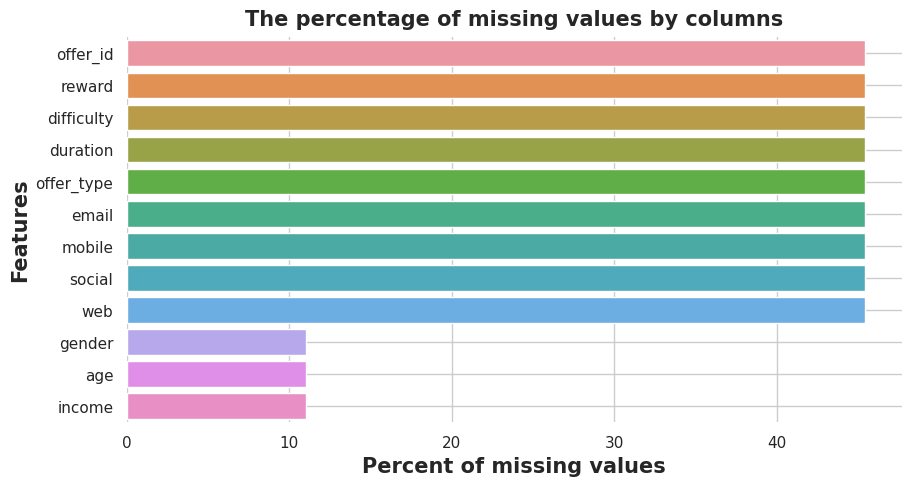

In [53]:
# Calculate the percentage of the missing values in each column, then put it
# into a data frame
df_na = (df.isnull().mean()) * 100
df_na = df_na.drop(df_na[df_na == 0].index)
df_na = df_na.sort_values(ascending=False)[0:15]

# Setting figure size and seaborn style
f, ax = plt.subplots(figsize=(10, 5))
sns.set(style='white', context='notebook')
sns.despine(left=True, bottom=True)

# Custom the chart
sns.barplot(x=df_na, y=df_na.index)
plt.title('The percentage of missing values by columns', fontsize=15,
          y=1.01, weight='bold')
plt.xlabel('Percent of missing values', fontsize=15, weight='bold')
plt.ylabel('Features', fontsize=15, weight='bold')

# Add grid style
ax.grid()

# 4. EDA

## 4.1. The impact of imcomplete profile on the success of an offer

In [23]:
# Filter rows with null values in the 'gender' column
null_profile = df[df['gender'].isnull()]

# Calculate offer completion rate for profiles with null gender values
null_rate = len(null_profile[null_profile['event'] == 'offer completed']) / len(null_profile[null_profile['event'] == 'offer received'])

# Filter rows with non-null values in the 'gender' column
com_profile = df[df['gender'].notnull()]

# Calculate offer completion rate for profiles with non-null gender values
regular_rate = len(com_profile[com_profile['event'] == 'offer completed']) / len(com_profile[com_profile['event'] == 'offer received'])

# Print the offer completion rates
print('Offer completion rate for profiles with null gender values: {}%'.format(round(null_rate * 100, 2)))
print('Offer completion rate for profiles with non-null gender values: {}%'.format(round(regular_rate * 100, 2)))


Offer completion rate for profiles with null gender values: 11.37%
Offer completion rate for profiles with non-null gender values: 48.22%


**Customers with imcomplete information are significantly less likely to use offers, so I will drop those rows for training models**

## 4.2. The distribution of gender

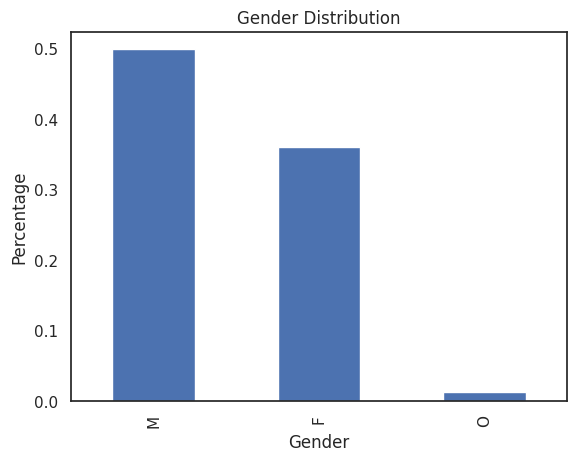

In [54]:
(profile_df.gender.value_counts()/profile_df.shape[0]).plot(kind="bar")
plt.ylabel('Percentage')
plt.xlabel('Gender')
plt.title('Gender Distribution');

**Approximately 50% of the collected Starbucks profiles identify as male, while around 35% identify as female. Only a small percentage of customers identify as 'Others'.**

Text(0.5, 1.0, 'Total counts of different events for each gender')

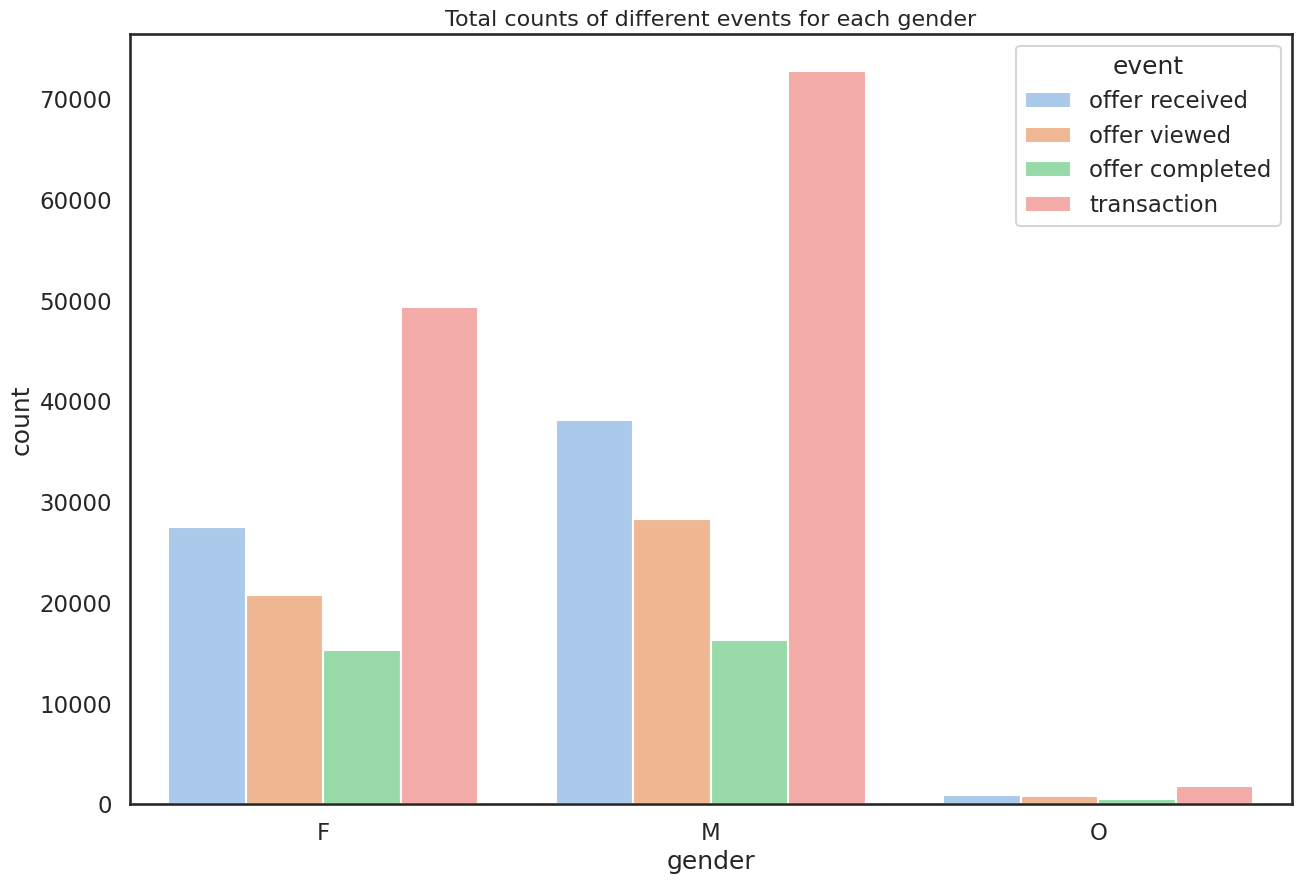

In [69]:
# Using subplot to count different events for each gender
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="gender", hue="event", data=df, palette="pastel")
plt.title("Total counts of different events for each gender", fontsize=16)

## 4.3. The distribution of age groups

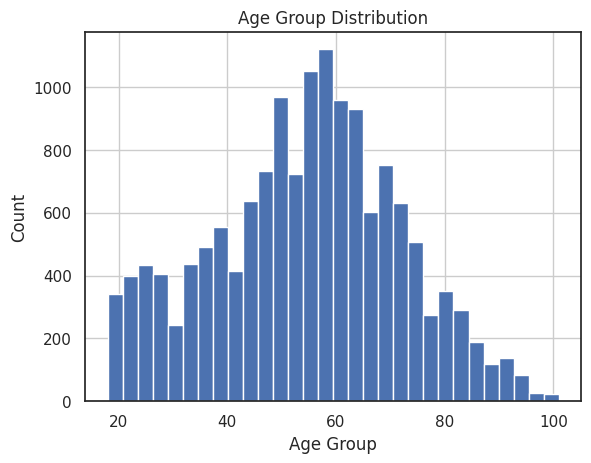

In [55]:
profile_df.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

**The age distribution appears to follow a fairly normal distribution. Towards the higher end, it starts to taper off, which is expected since it is uncommon to encounter individuals older than 90.**

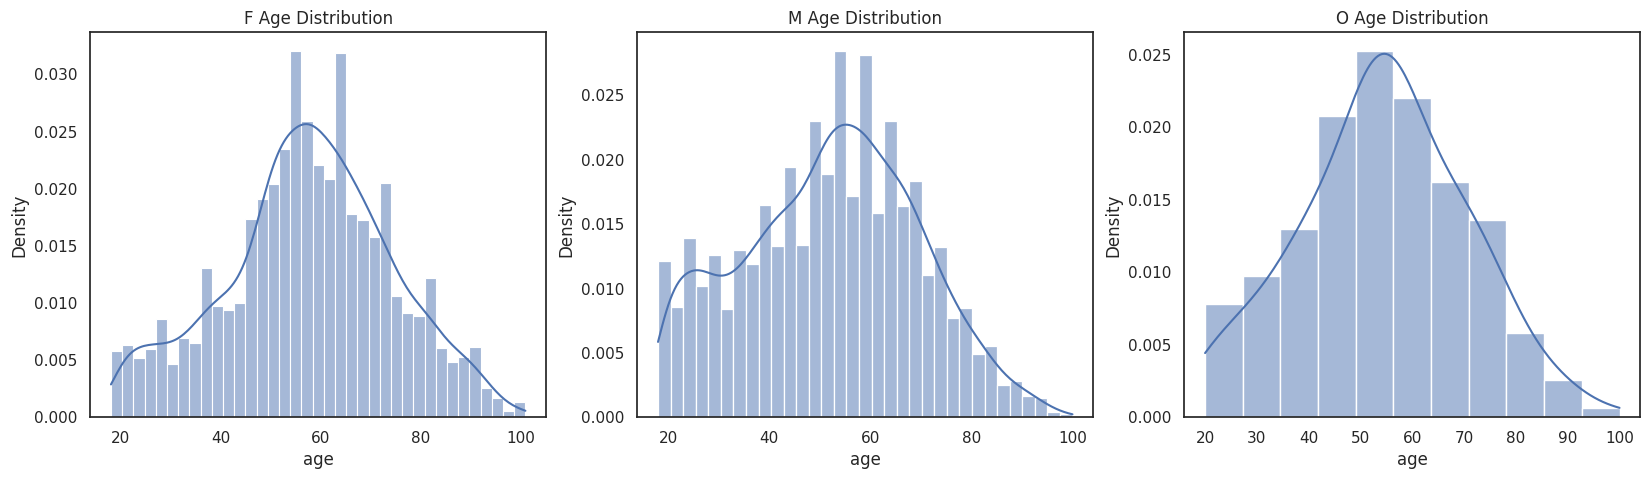

In [56]:
# Get unique gender values and filter out None
unique_genders = [gender for gender in profile_df.gender.unique() if gender is not None]

# Create subplots based on the number of unique genders
num_subplots = len(unique_genders)
fig, ax = plt.subplots(1, num_subplots, figsize=[20, 5])

# Plot age distributions for each gender
for i, gender in enumerate(unique_genders):
    ax[i] = sns.histplot(profile_df.query(f'gender == "{gender}"')['age'], 
                         ax=ax[i], kde=True, stat="density")
    
    ax[i].title.set_text(f'{gender} Age Distribution')

plt.show()

## 4.4. The distribution of income

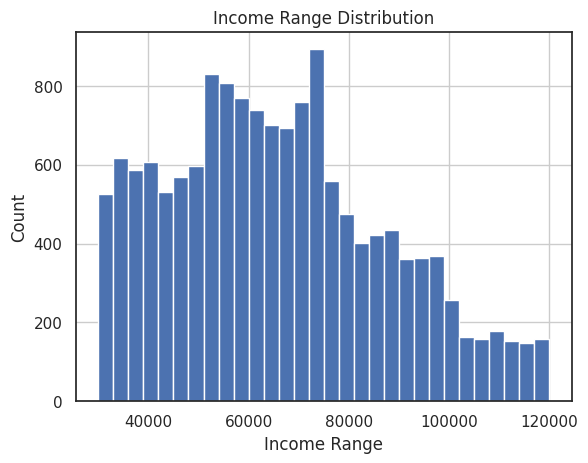

In [57]:
profile_df.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

**The income distribution displays a slight right skew. The peak count appears to occur around the $75,000 income threshold, with the majority earning less than that amount.**

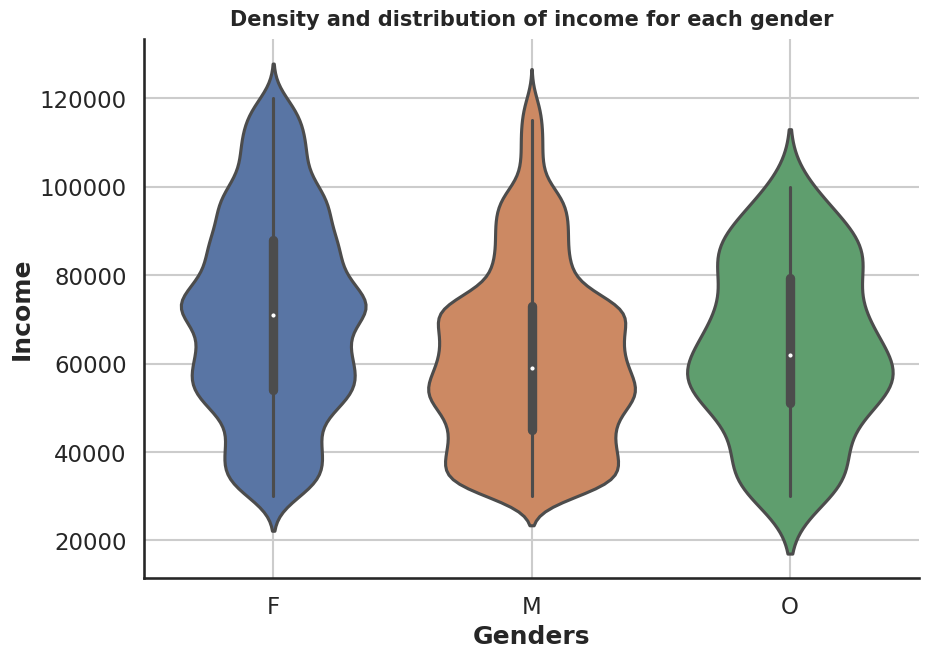

In [61]:
# Setting figure and seaborn style
f, ax = plt.subplots(figsize=(10, 7))
sns.set(style='white', context='talk')
sns.despine()

# Using violinplot to display density and distribtuion of income
viz_5 = sns.violinplot(data=profile_df, x='gender', y='income')
viz_5.set_title('Density and distribution of income for each gender',
                y=1.01, fontsize=15, weight='bold')
viz_5.set_ylabel('Income', weight='bold')
viz_5.set_xlabel('Genders', weight='bold')

# Add grid style
ax.grid()

**The income distribution appears to be relatively uniform across genders, except for males. It is noticeable that a significant proportion of male members have incomes below $80,000.**

## 4.5. The number of membership started by each year

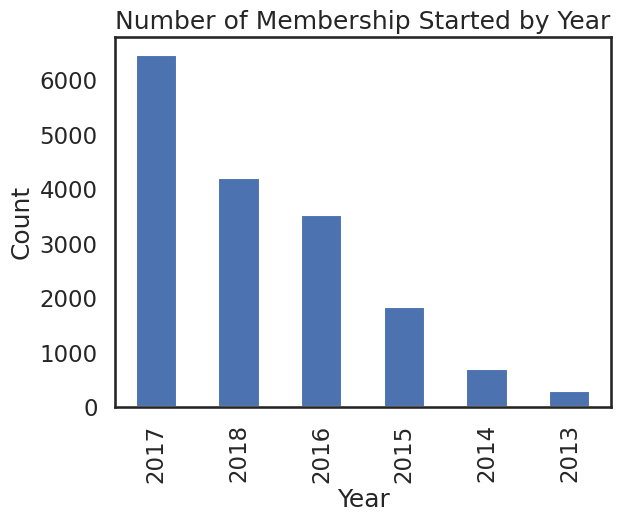

In [29]:
profile_df.year.value_counts().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Membership Started by Year');

**Starbucks experienced a substantial increase in new memberships in 2017, with an impressive figure of over 6000. However, the number of new members joining Starbucks in 2018 was significantly lower, which is somewhat surprising, with only around 40000 new members.**

## 4.6. The number of events for each offer

Text(0.5, 1.0, 'Total counts of different events for each offer')

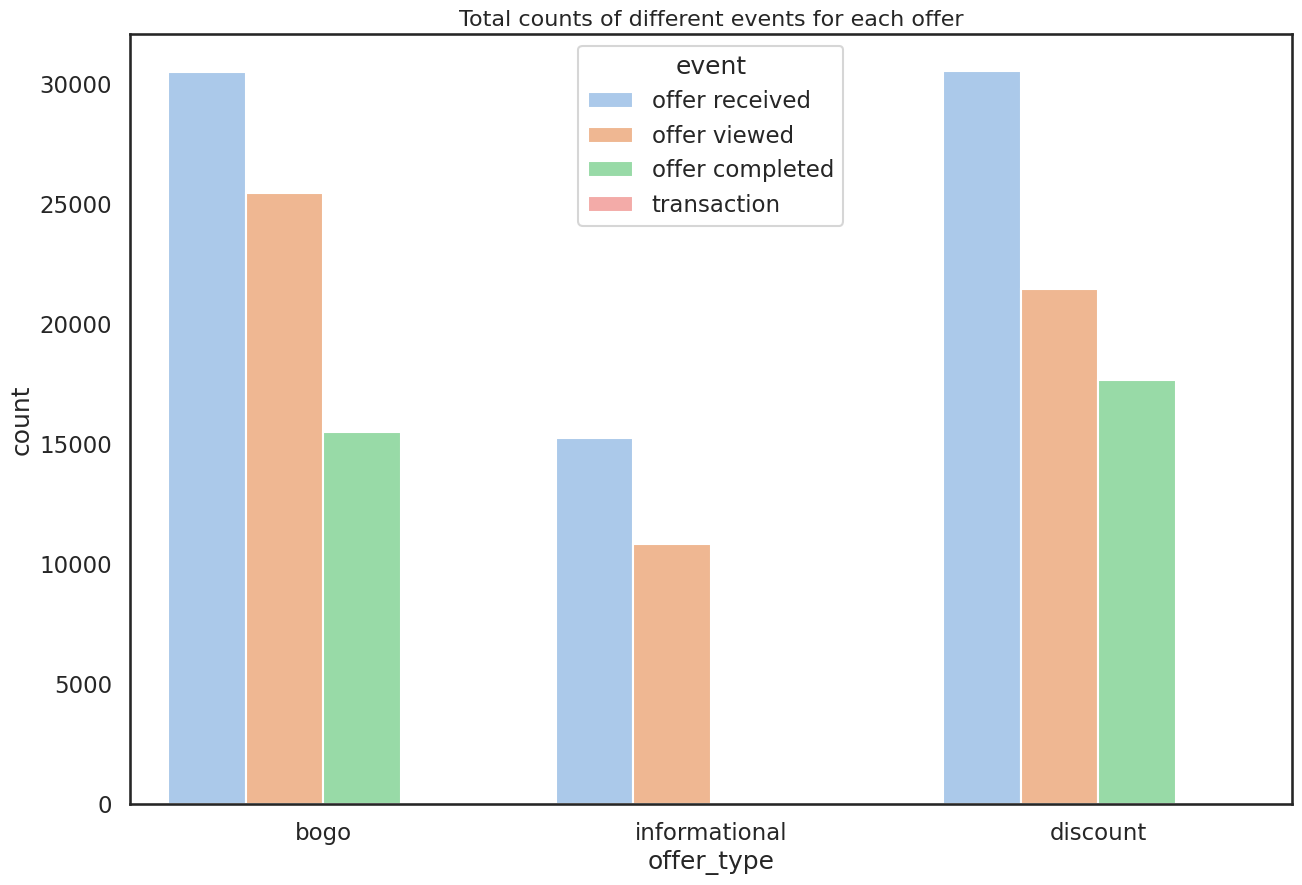

In [66]:
# Using subplot to count different events for each offer
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="offer_type", hue="event", data=df, palette="pastel")
plt.title("Total counts of different events for each offer", fontsize=16)

**It is evident that members have received an equal number of discounts and BOGO (buy one, get one) offers. Besides, there is a higher number of views for the BOGO offer, indicating its potential attractiveness. However, the majority of people have successfully completed the discount offer.**

In [31]:
print("The total counts of different events for the BOGO offer are:")
print(df[df["offer_type"] == "bogo"]["event"].value_counts())

print("\n\nThe total counts of different events for the discount offer are:")
print(df[df["offer_type"] == "discount"]["event"].value_counts())

The total counts of different events for the BOGO offer are:
offer received     30499
offer viewed       25449
offer completed    15501
Name: event, dtype: int64


The total counts of different events for the discount offer are:
offer received     30543
offer viewed       21445
offer completed    17681
Name: event, dtype: int64


## 4.7. The impact of channels on the completion of an offer

In [67]:
channel_type = {0: ['web', 'email', 'mobile', 'social'], 
                1: ['web', 'email', 'mobile'],
                2: ['email', 'mobile', 'social'],
                3: ['web', 'email']}

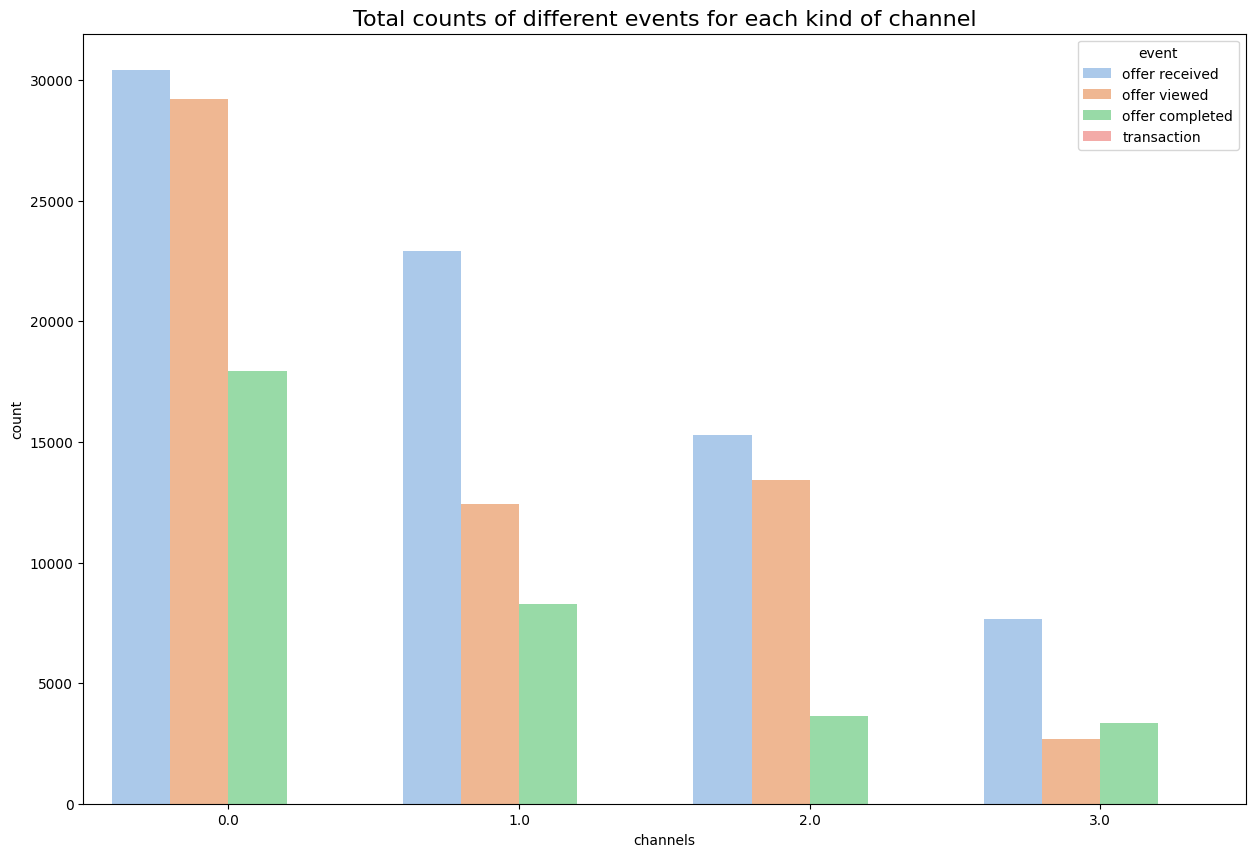

In [66]:
# Using subplot to count different events for each offer
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x="channels", hue="event", data=df, palette="pastel")
plt.title("Total counts of different events for each kind of channel", fontsize=16);

# 5. Modelling and Evaluation

In [32]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time

## 5.1. Data Preparation

In [33]:
def create_dummy_columns(df, column_list):
    for column_name in column_list:
        # Create dummy columns using one-hot encoding
        dummy_columns = pd.get_dummies(df[column_name])

        # Concatenate the original DataFrame with the dummy columns
        df = pd.concat([df, dummy_columns], axis=1)

        # Drop the original column
        df = df.drop(columns=[column_name], axis=1)

    return df

In [34]:
# Drop all rows with null values in the 'income' column.
df.dropna(subset=['income'], inplace = True)

# Apply 'create_dummy_columns' function to 'event', 'gender', 'offer_type'.
df = create_dummy_columns(df, ['event', 'gender', 'offer_type'])

# Fill all null values with 0
df.fillna(0, inplace = True)

In [35]:
# Split dataset to X and y
X = df.drop(columns=['customer_id', 'offer_id', 'became_member_on', 'offer completed',
                     'offer received', 'offer viewed', 'transaction'], axis=1)
y = df['offer completed']

In [36]:
X.head()

,time,amount,age,income,year,reward,difficulty,duration,email,mobile,social,web,F,M,O,bogo,discount,informational
0,0,0.0,75.0,100000.0,2017,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1,0,0,1,0,0
1,6,0.0,75.0,100000.0,2017,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1,0,0,1,0,0
2,132,0.0,75.0,100000.0,2017,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1,0,0,1,0,0
3,408,0.0,68.0,70000.0,2018,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0,1,0,1,0,0
4,420,0.0,68.0,70000.0,2018,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0,1,0,1,0,0


In [37]:
# Normalize data using MinMaxScaler
scaler = MinMaxScaler()
normalize_col = list(X.columns)
X[normalize_col] = scaler.fit_transform(X[normalize_col])

In [38]:
X.head()

,time,amount,age,income,year,reward,difficulty,duration,email,mobile,social,web,F,M,O,bogo,discount,informational
0,0.000000,0.0,0.686747,0.777778,0.8,0.5,0.25,0.7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.008403,0.0,0.686747,0.777778,0.8,0.5,0.25,0.7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.184874,0.0,0.686747,0.777778,0.8,0.5,0.25,0.7,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.571429,0.0,0.602410,0.444444,1.0,0.5,0.25,0.7,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.588235,0.0,0.602410,0.444444,1.0,0.5,0.25,0.7,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [39]:
# Split X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((204291, 18), (68097, 18), (204291,), (68097,))

In [62]:
y.value_counts()

0    240318
1     32070
Name: offer completed, dtype: int64

**From here, we can see that the dataset is imbalanced, so I will use F1-score as the main metric.**

## 5.2. Training and Model Comparison

In [40]:
# List of model names
model_names = ['Logistic Regression', 'Ada Booster', 'Random Forest', 'K Neighbors', 'Decision Tree',
               'Gradient Boosting', 'XGB Classifier', 'LGBM Classifier']

# List of classifier objects corresponding to the models
classifiers = [LogisticRegression(), AdaBoostClassifier(), RandomForestClassifier(),
               KNeighborsClassifier(), DecisionTreeClassifier(),
               GradientBoostingClassifier(), XGBClassifier(), LGBMClassifier()]

# Lists to store f1 scores, accuracy scores, and model times
f1_scores = []
accuracy_scores = []
all_model_time = []

# Loop through each classifier
for classifier in classifiers:
    # Start the timer
    start_time = time.time()
    
    # Train the classifier on the training data
    classifier.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = classifier.predict(X_test)
    
    # Calculate and store the f1, accuracy score, and the time taken for modeling
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    all_model_time.append(time.time() - start_time)

# Create a pandas DataFrame to store the results
res_df = pd.DataFrame({'F1-Score': f1_scores, 'Accuracy': accuracy_scores, 'Modeling Time': all_model_time},
                      index=model_names)

# Sort the DataFrame by the 'F1-Score' column
res_df = res_df.sort_values(by='F1-Score')


In [63]:
# Display the comparison table
res_df

,F1-Score,Accuracy,Modeling Time
Logistic Regression,0.003738,0.882594,2.930612
K Neighbors,0.174737,0.869612,90.896791
Random Forest,0.254087,0.859979,21.224851
Ada Booster,0.324115,0.892330,11.588209
Decision Tree,0.460701,0.874855,1.038759
Gradient Boosting,0.528689,0.905429,34.378248
XGB Classifier,0.586562,0.907382,27.402846
LGBM Classifier,0.595501,0.909688,2.206612


**Based on the result above, the LGBM Classifier is the most accurate model, exhibiting the highest f1-score of 0.59 and an accuracy rate of 91%. Thus, I will utilize this model to assess the significance of features.**

## 5.3. Feature Importance

In [43]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

In [44]:
accuracy = accuracy_score(y_test, lgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1-Score:", f1_score(y_test, lgb_pred))
print('Classification Report: \n', classification_report(y_test, lgb_pred))

Accuracy: 90.97%
F1-Score: 0.595501183898974
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     60105
           1       0.63      0.57      0.60      7992

    accuracy                           0.91     68097
   macro avg       0.79      0.76      0.77     68097
weighted avg       0.91      0.91      0.91     68097



In [45]:
# Get all feature names
labels = X_train.columns.tolist()

# Create a DataFrame for feature importances
feature_imp = pd.DataFrame({'Feature': labels, 'feat_imp': lgb.feature_importances_})

# Calculate the importance percentage
feature_imp['Importance_Percent'] = (feature_imp['feat_imp'] / feature_imp['feat_imp'].sum()) * 100
feature_imp['Importance_Percent'] = feature_imp['Importance_Percent'].round(2)

# Sort the features by importance
feature_imp = feature_imp.sort_values(by='Importance_Percent', ascending=False).reset_index(drop=True)

# Display
feature_imp

,Feature,feat_imp,Importance_Percent
0,time,1343,44.77
1,income,493,16.43
2,age,390,13.00
3,year,227,7.57
4,reward,199,6.63
5,difficulty,102,3.40
6,social,79,2.63
7,duration,56,1.87
8,M,46,1.53
9,F,24,0.80


**The three most influential factors that affect a customer's completion of an offer are the duration of response time, the customer's income, and their age.**